<a href="https://colab.research.google.com/github/Udinanon/CV-Project-Prototypes/blob/main/Hand_Segmentation_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Old Setup Code
will have to remove/reoder when the new version is done




In [13]:

%ls
%cd drive/MyDrive/
%cd Colab_Notebooks/faces_datasets/
# move to correct folder

drive/  sample_data/
/content/drive/MyDrive
/content/drive/MyDrive/Colab_Notebooks/faces_datasets


In [ ]:
# remove useless files
!rm -dr detect_hands/
!rm -f egohands_data.zip
!rm -dr egohands/

rm: cannot remove 'egohands/': No such file or directory


In [ ]:
#unpack the hand_pver_face dataset 
!tar -xvzf hand_over_face_corrected.tar.gz
#remove dataset file
!rm -f hand_over_face_corrected.tar.gz

In [12]:
# basic imports
import torchvision
import numpy as np
import torch
from PIL import Image
import os
os.getcwd()


'/content'

In [ ]:
# import Mask RCNN model 
# https://pytorch.org/vision/master/models/mask_rcnn.html

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()


# loading one image and visualizing the model
very basic

In [ ]:
import torchvision.transforms as transforms
imsize = 256

loader = transforms.Compose([transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

model(image_loader("images/train/CARDS_LIVINGROOM_T_B_frame_0001.jpg"))

In [ ]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

import cv2, random
import matplotlib.pyplot as plt

image_path = "images/train/CARDS_LIVINGROOM_T_B_frame_0001.jpg"

def get_prediction(img_path, threshold):
  img = Image.open(img_path)
  transform = transforms.Compose([transforms.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class


def random_colour_masks(image):
  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
  coloured_mask = np.stack([r, g, b], axis=2)
  return coloured_mask

def instance_segmentation_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  masks, boxes, pred_cls = get_prediction(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(masks)):
    rgb_mask = random_colour_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

instance_segmentation_api(image_path)


### BTW how to read all sys info on the machine

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("CPU")
!cat /proc/cpuinfo
print("RAM")
!cat /proc/meminfo

print("GPU?")
tf.test.gpu_device_name()
device_lib.list_local_devices()

# First version of the Datset
works only for egohands and does not support masks, not sufficent


In [ ]:
# Creating the datasets
import os
import numpy as np
import csv
import torch
from PIL import Image


class EgoHandsDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms, test = False):
    self.root = root
    self.transforms = transforms
    # load all image files, sorting them to
    # ensure that they are aligned
    if test:
      path = os.path.join(root, "images", "test")
    else:
      path = os.path.join(root, "images", "train")

    self.imgs = [x for x in sorted(os.listdir(path)) if x.endswith(".jpg")]
    mask_file_path = [x for x in sorted(os.listdir(path)) if x.endswith(".csv")][0]
    print(mask_file_path)
    print(os.path.join(path, mask_file_path))
    self.mask_entries = []
    with open(os.path.join(path, mask_file_path)) as mask_file:
      mask_csv = csv.reader(mask_file)
      next(mask_csv)
      for line in mask_csv:
        self.mask_entries.append([line[0], int(line[4]), int(line[5]), int(line[6]), int(line[7])])
    print("LEN IMGS", len(self.imgs))
    print("LEN MASK", len(self.mask_entries))
    

  def __getitem__(self, idx):
    # load image
    img_path = os.path.join(self.root, "images", "test", self.imgs[idx])
    img = Image.open(img_path).convert("RGB")

    # read the entries for the bounding boxes for this image
    image_filename = "images/test/" + self.imgs[idx]        
    entries = [entry for entry in self.mask_entries if entry[0] == image_filename]

    # get bounding box coords
    num_objs = len(entries)
    boxes = []
    for entry in entries:
      boxes.append([entry[1], entry[2], entry[3], entry[4]])

    # convert everything into a torch.Tensor
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    # there is only one class
    labels = torch.ones((num_objs,), dtype=torch.int64)
    image_id = torch.tensor([idx])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    # suppose all instances are not crowd
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms is not None:
      img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
    return len(self.imgs)


# this code come from https://github.com/pytorch/vision/blob/6315358dd06e3a2bcbe9c1e8cdaa10898ac2b308/references/detection/transforms.py#L17
# due to the transforms needing to be able to work both on the oimage and the boxes, for data augmentation
from torchvision.transforms import functional as F

class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

def get_transform():
    transforms = []
    transforms.append(ToTensor())
    return Compose(transforms)

print(os.getcwd())



/content/drive/MyDrive/Colab_Notebooks/faces_datasets
test_labels.csv
./images/test/test_labels.csv
LEN IMGS 36
LEN MASK 108


tensor([[460., 177., 984., 653.],
        [430., 274., 488., 444.]])

##tester for the dataset, works 


In [ ]:
import torchvision

# from https://github.com/pytorch/vision/blob/main/references/detection/utils.py again
def collate_fn(batch):
    return tuple(zip(*batch))

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
egohands = EgoHandsDataset(".", transforms = get_transform(), test = True)
data_loader = torch.utils.data.DataLoader(
 egohands, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x) 

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

test_labels.csv
./images/test/test_labels.csv
LEN IMGS 36
LEN MASK 108


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## experiment for the HOF dataset


In [ ]:
## This dataset is fucking trash jesus
#  thanks https://github.com/guglielmocamporese/hands-segmentation-pytorch/blob/master/dataloader.py
class HandOverFaceDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms):
    self.root = root
    self.transforms = transforms
    # load all image files, sorting them to
    # ensure that they are aligned
    self.imgs = list(sorted(os.listdir(os.path.join(root, "hand_over_face", "images_resized"))))
    self.masks = list(sorted(os.listdir(os.path.join(root, "hand_over_face", "masks"))))

  def __getitem__(self, idx):
    # load images and masks
    img_path = os.path.join(self.root, "hand_over_face", "images_resized", self.imgs[idx])
    mask_path = os.path.join(self.root, "hand_over_face", "masks", self.masks[idx])
    img = Image.open(img_path).convert("RGB")
    # note that we haven't converted the mask to RGB,
    # because each color corresponds to a different instance
    # with 0 being background

    ## YEAH that's not true here, we need to count and separate the masks somehow
    ## the annotations have some info, maybe we can use those??
    mask = Image.open(mask_path)
    # convert the PIL Image into a numpy array
    mask = np.array(mask)
    # instances are encoded as different colors
    obj_ids = np.unique(mask)
    # first id is the background, so remove it
    obj_ids = obj_ids[1:]

    # split the color-encoded mask into a set
    # of binary masks
    masks = mask == obj_ids[:, None, None]

    # get bounding box coordinates for each mask
    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes.append([xmin, ymin, xmax, ymax])

    # convert everything into a torch.Tensor
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    # there is only one class
    labels = torch.ones((num_objs,), dtype=torch.int64)
    masks = torch.as_tensor(masks, dtype=torch.uint8)

    image_id = torch.tensor([idx])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    # suppose all instances are not crowd
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["masks"] = masks
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms is not None:
        img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
    return len(self.imgs)

# New Dataset approach

## Dataset setup with better scripts

In [ ]:
# from here https://github.com/guglielmocamporese/hands-segmentation-pytorch/blob/master/scripts/download_datasets.sh

%%shell
# Download datasets
DATA_BASE_PATH="."
mkdir -p "${DATA_BASE_PATH}"

In [ ]:
%%shell
# HandOverFace (HOF)
mkdir -p "./HOF"
gdown "https://drive.google.com/uc?id=1hHUvINGICvOGcaDgA5zMbzAIUv7ewDd3" -O "./HOF/hand_over_face_corrected.tar.gz"
tar -xvf "./HOF/hand_over_face_corrected.tar.gz" -C "./HOF"
rm "./HOF/hand_over_face_corrected.tar.gz"

In [ ]:
%%shell
# EgoHands
wget "http://vision.soic.indiana.edu/egohands_files/egohands_data.zip" -O "${DATA_BASE_PATH}/egohands_data.zip"
unzip "${DATA_BASE_PATH}/egohands_data.zip" -d "${DATA_BASE_PATH}/egohands_data"
rm "${DATA_BASE_PATH}/egohands_data.zip"

## working on egohands dataset

In [ ]:
import scipy.io
from pprint import pprint
from PIL import Image, ImageDraw
## allows us to geenrate masks from the egohands datasets and not just boxes
# all from https://github.com/guglielmocamporese/hands-segmentation-pytorch/blob/d4643f3a2137e90e60b8eba0d5bb06bb25552841/dataloader.py#L356

data_base_path = os.path.join("EGO", "egohands_data")
frame_tmpl='frame_{:04d}.jpg'
metadata = scipy.io.loadmat(os.path.join(data_base_path, 'metadata.mat'))
annotations = metadata['video'][0]
x = list(annotations[0])
video_id, _, _, _, _, _, labeled_frames = x # more info the readme
video_id = video_id[0]
labeled_frames = labeled_frames[0]
frame_ann = labeled_frames[0]
frame_id = frame_ann[0].reshape(-1)[0]
image_paths = []
masks_poly = []
polygons = []
for idx, ll in enumerate(frame_ann):
  if (idx > 0) and len(ll) > 0:
    p = [tuple(pp) for pp in ll]
    polygons += [p]
print(len(polygons))
image_path = os.path.join(data_base_path, '_LABELLED_SAMPLES', video_id, frame_tmpl.format(frame_id))
image = Image.open(image_path)
image


w, h = image.size
mask = Image.new('L', (w, h), 0)
ImageDraw.Draw(mask).polygon(polygons[1], outline=255, fill=255)
mask



In [8]:
from torch.utils.data import Dataset
import scipy.io
from pprint import pprint
from PIL import Image, ImageDraw
import torchvision.transforms as transforms
import os
import numpy as np
import csv
import torch
from PIL import Image
import torchvision

## valid egohands dataset with masks

./egohands_data/_LABELLED_SAMPLES/CARDS_COURTYARD_B_T/frame_0011.jpg


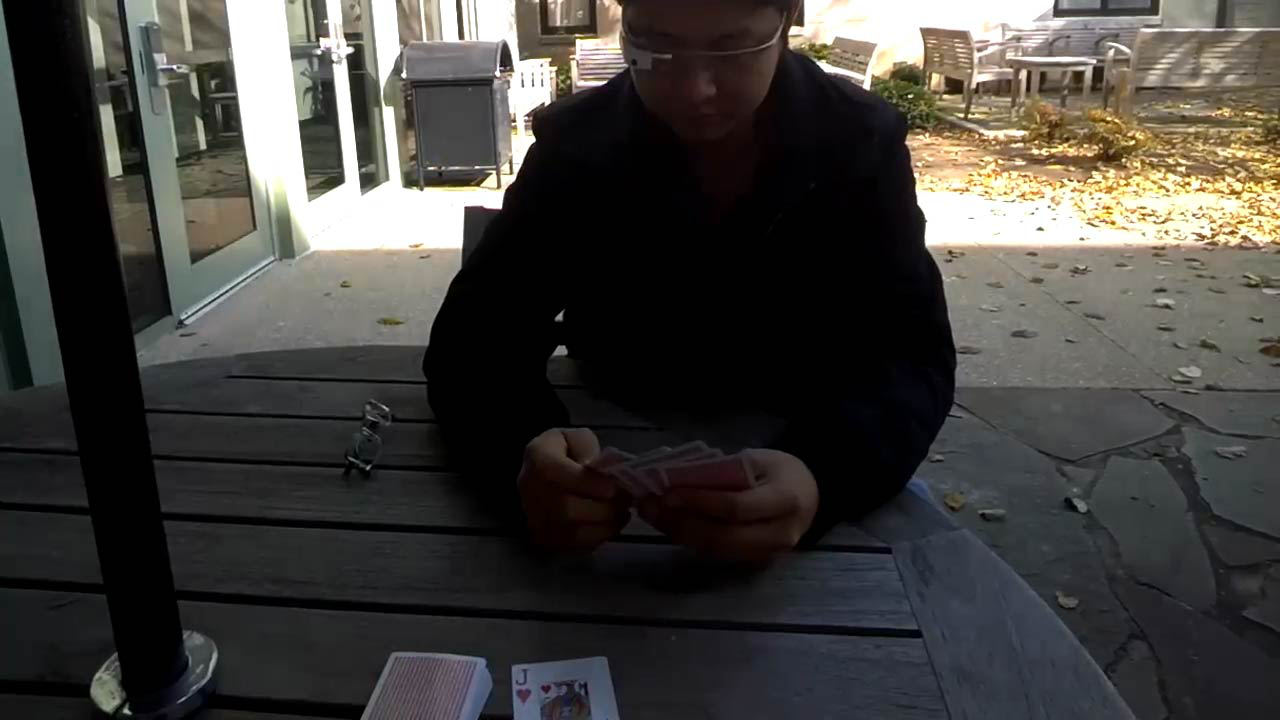

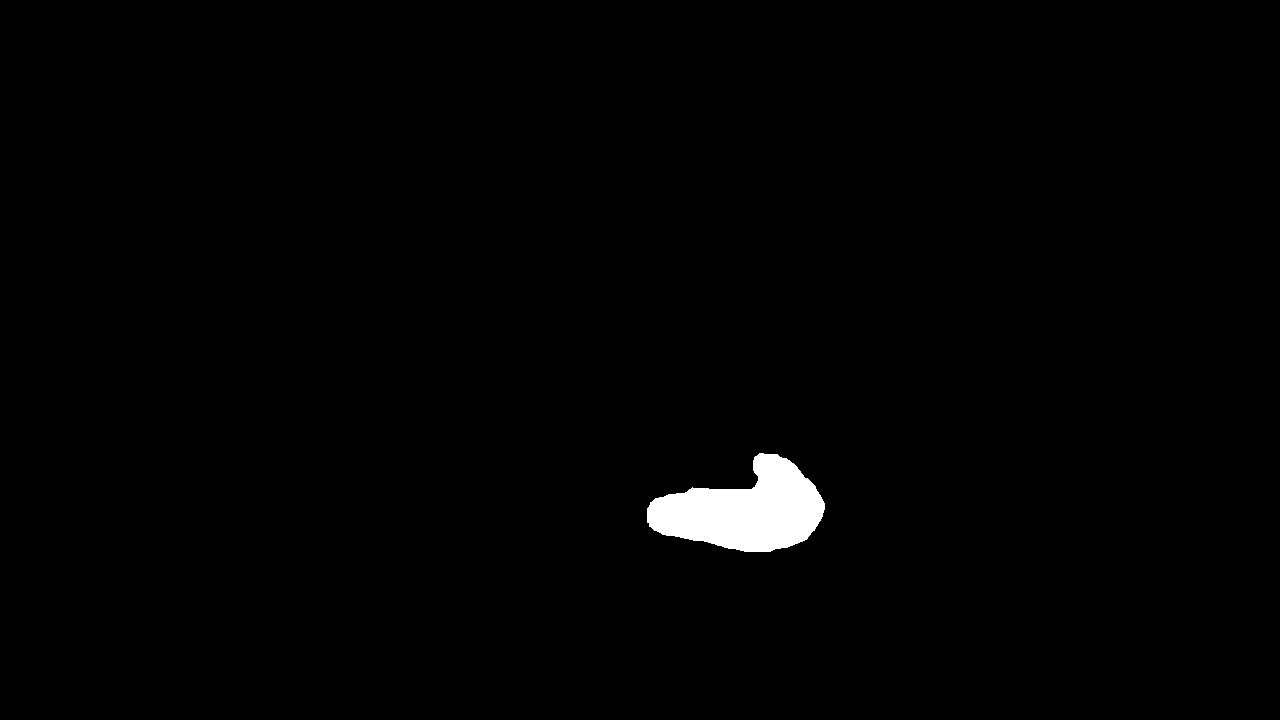

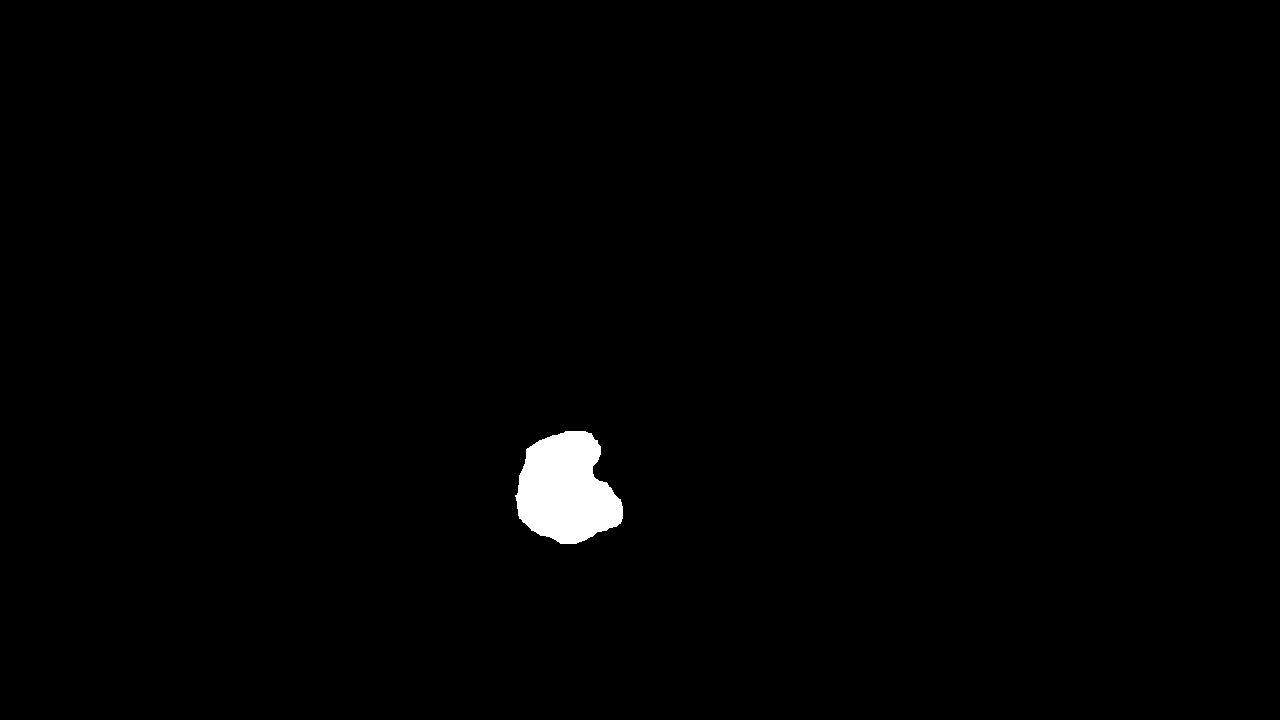

(tensor([[[0.4235, 0.2471, 0.0235,  ..., 0.3333, 0.3255, 0.3216],
          [0.4275, 0.2627, 0.0392,  ..., 0.3333, 0.3255, 0.3216],
          [0.4275, 0.2902, 0.0667,  ..., 0.3333, 0.3255, 0.3216],
          ...,
          [0.0824, 0.0824, 0.0824,  ..., 0.1098, 0.1098, 0.1098],
          [0.0824, 0.0824, 0.0824,  ..., 0.1098, 0.1098, 0.1098],
          [0.0824, 0.0824, 0.0824,  ..., 0.1098, 0.1098, 0.1098]],
 
         [[0.4902, 0.3137, 0.0824,  ..., 0.3373, 0.3294, 0.3255],
          [0.4941, 0.3294, 0.0980,  ..., 0.3373, 0.3294, 0.3255],
          [0.4941, 0.3569, 0.1255,  ..., 0.3373, 0.3294, 0.3255],
          ...,
          [0.0824, 0.0824, 0.0824,  ..., 0.1098, 0.1098, 0.1098],
          [0.0824, 0.0824, 0.0824,  ..., 0.1098, 0.1098, 0.1098],
          [0.0824, 0.0824, 0.0824,  ..., 0.1098, 0.1098, 0.1098]],
 
         [[0.4667, 0.2902, 0.0627,  ..., 0.3059, 0.2980, 0.2941],
          [0.4706, 0.3059, 0.0784,  ..., 0.3059, 0.2980, 0.2941],
          [0.4706, 0.3333, 0.1059,  ...,

In [48]:
class EgoHandsDataset(Dataset):
    """
        EgoHands dataset from http://vision.soic.indiana.edu/projects/egohands.
        Images and masks of dims [720, 1280].
        modified to support instance segmentation buy generting multiple masks
        one for each hand
    """
    def __init__(self, data_base_path, image_transform=None, 
                 mask_transform=None, seed=1234, frame_tmpl='frame_{:04d}.jpg', 
                 mask_shape=None):
        super(EgoHandsDataset, self).__init__()
        self.data_base_path = data_base_path
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.seed = seed
        self.frame_tmpl = frame_tmpl
        self.metadata = scipy.io.loadmat(os.path.join(self.data_base_path, 'metadata.mat'))
        self.mask_shape = mask_shape
        self.image_paths, self.mask_poly = self._get_paths()

    def _compute_masks(self, polygons, height, width):
        masks = []
        for poly in polygons:
              mask = Image.new('L', (width, height), 0)
              ImageDraw.Draw(mask).polygon(poly, outline=255, fill=255)
              mask = np.array(mask)
              masks.append(mask)
        return masks

    def _get_paths(self):

        annotations = self.metadata['video'][0] # 48 annotations (of the 48 videos)
        image_paths = []
        masks_poly = []
        for x in annotations:
            x = list(x)
            video_id, _, _, _, _, _, labeled_frames = x # more info the readme
            video_id = video_id[0]
            labeled_frames = labeled_frames[0]

            # Get frame annotation
            for frame_ann in labeled_frames:
                frame_id = frame_ann[0].reshape(-1)[0]
                polygons = []
                for idx, ll in enumerate(frame_ann):
                    if (idx > 0) and len(ll) > 0:
                        p = [tuple(pp) for pp in ll]
                        polygons += [p]
                masks_poly += [polygons]

                image_path = os.path.join(self.data_base_path, '_LABELLED_SAMPLES', video_id, self.frame_tmpl.format(frame_id))
                image_paths += [image_path]

        # Split data
        num_samples = len(image_paths)
        idxs = np.arange(num_samples)
        np.random.seed(self.seed)
        np.random.shuffle(idxs)
        return image_paths, masks_poly

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        # Load image and mask
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.mask_shape is None:
            w, h = image.size
        else:
            h, w = self.mask_shape
        masks = self._compute_masks(self.mask_poly[idx], h, w)
        target = {}
        num_objs = len(masks)
        boxes = []
        for i in range(num_objs):
            
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        # Transforms
        if self.image_transform is not None:
            image = self.image_transform(image)
        else:
          tensor_trans = transforms.Compose([transforms.ToTensor()])
          image = tensor_trans(image)
        return image, target



model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
egohands = EgoHandsDataset("./egohands_data/")
egohands[0]

### tester for it 

In [38]:

def collate_fn(batch):
    return tuple(zip(*batch))

egohands = EgoHandsDataset("./egohands_data/")
egohands[0]
data_loader = torch.utils.data.DataLoader(
    egohands, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=collate_fn
)
# For Training
images,targets = next(iter(data_loader))
print(len(images))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


2


## working on HOF dataset


<Element 'annotation' at 0x7f916c189fb0>
0
1
0


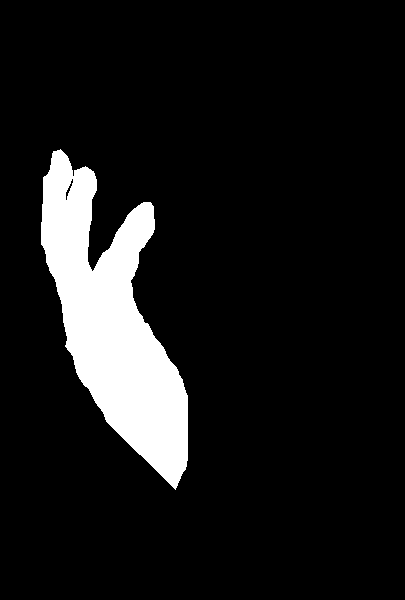

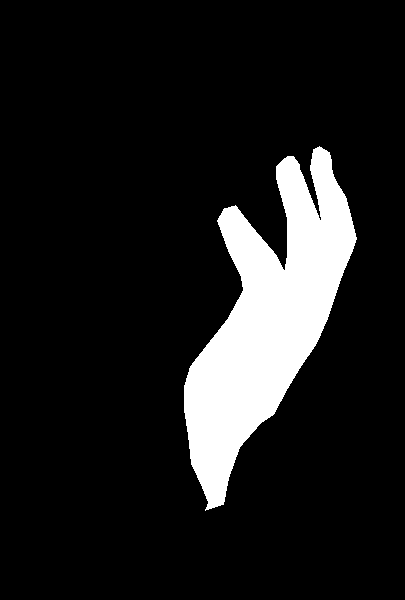

In [65]:
## loosely based on https://github.com/kekeller/LabelMeMaskParser


import xml.etree.ElementTree as et

def parsePolygon( etelem ):
    points = []
    for pt in etelem.findall('pt'):
        num = pt.find('x').text
        if '.' in num: 
            tx = int(float(num))
        else:
            tx = int(num)
        num = pt.find('y').text
        if '.' in num:  
            ty = int(float(num))
        else:
            ty = int(num)

        points.append(tx)
        points.append(ty)
    return points


def parse_xml(file):
    tree = et.parse(file)
    root = tree.getroot()
    file_name = root.findall('filename')[0].text
    polygon = []
    name_list = []
    image_size = [int(root.findall('./imagesize/ncols')[0].text), int(root.findall('./imagesize/nrows')[0].text)]

    for lmobj in root.findall('object'):
        deleted = lmobj.find('deleted').text
        if deleted=='1':
            continue
        polygon.append(parsePolygon(lmobj.find('polygon')))
        
    masks = []
    for poly in polygon:
        img = Image.new("RGB", image_size, (0, 0, 0) )
        color = (255,255,255)
        if (len(poly) < 3): continue
        ImageDraw.Draw(img).polygon(poly, outline=color, fill=color)
        mask = np.array(img)
        masks.append(mask)
    return masks


In [66]:

class HOFDataset(Dataset):
    """
        HandOverFace dataset from https://drive.google.com/file/d/1hHUvINGICvOGcaDgA5zMbzAIUv7ewDd3/view?usp=drive_open.
        Images and masks of dims [384, 216]
        modified to support instance segmentation
        https://github.com/aurooj/Hand-Segmentation-in-the-Wild
    """
    def __init__(self, data_base_path, image_transform=None, 
                 mask_transform=None, seed=1234):
        super(HOFDataset, self).__init__()
        self.data_base_path = data_base_path
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.seed = seed
        self.image_paths, self.mask_paths = self._get_paths()

    def _get_paths(self):

        # Image paths
        image_names = sorted(os.listdir(os.path.join(self.data_base_path, 'images_resized')))
        image_paths = [os.path.join(self.data_base_path, 'images_resized', f) for f in image_names]

        # Mask paths
        mask_paths = [f.replace('images_resized', 'annotations').replace('.jpg', '.xml') for f in image_paths]

        # Split data
        num_samples = len(image_paths)
        idxs = np.arange(num_samples)
        np.random.seed(self.seed)
        np.random.shuffle(idxs)
        return image_paths, mask_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        # Load image and mask
        image = Image.open(self.image_paths[idx])
        mask_path = self.mask_paths[idx]
        masks = parse_xml(mask_path)

        #create target for returning
        target = {}
        num_objs = len(masks)
        boxes = []
        for i in range(num_objs):
            #generate the bounding box
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        # Transforms
        if self.image_transform is not None:
            image = self.image_transform(image)

        return image, target

<Element 'annotation' at 0x7f9176e77230>
0


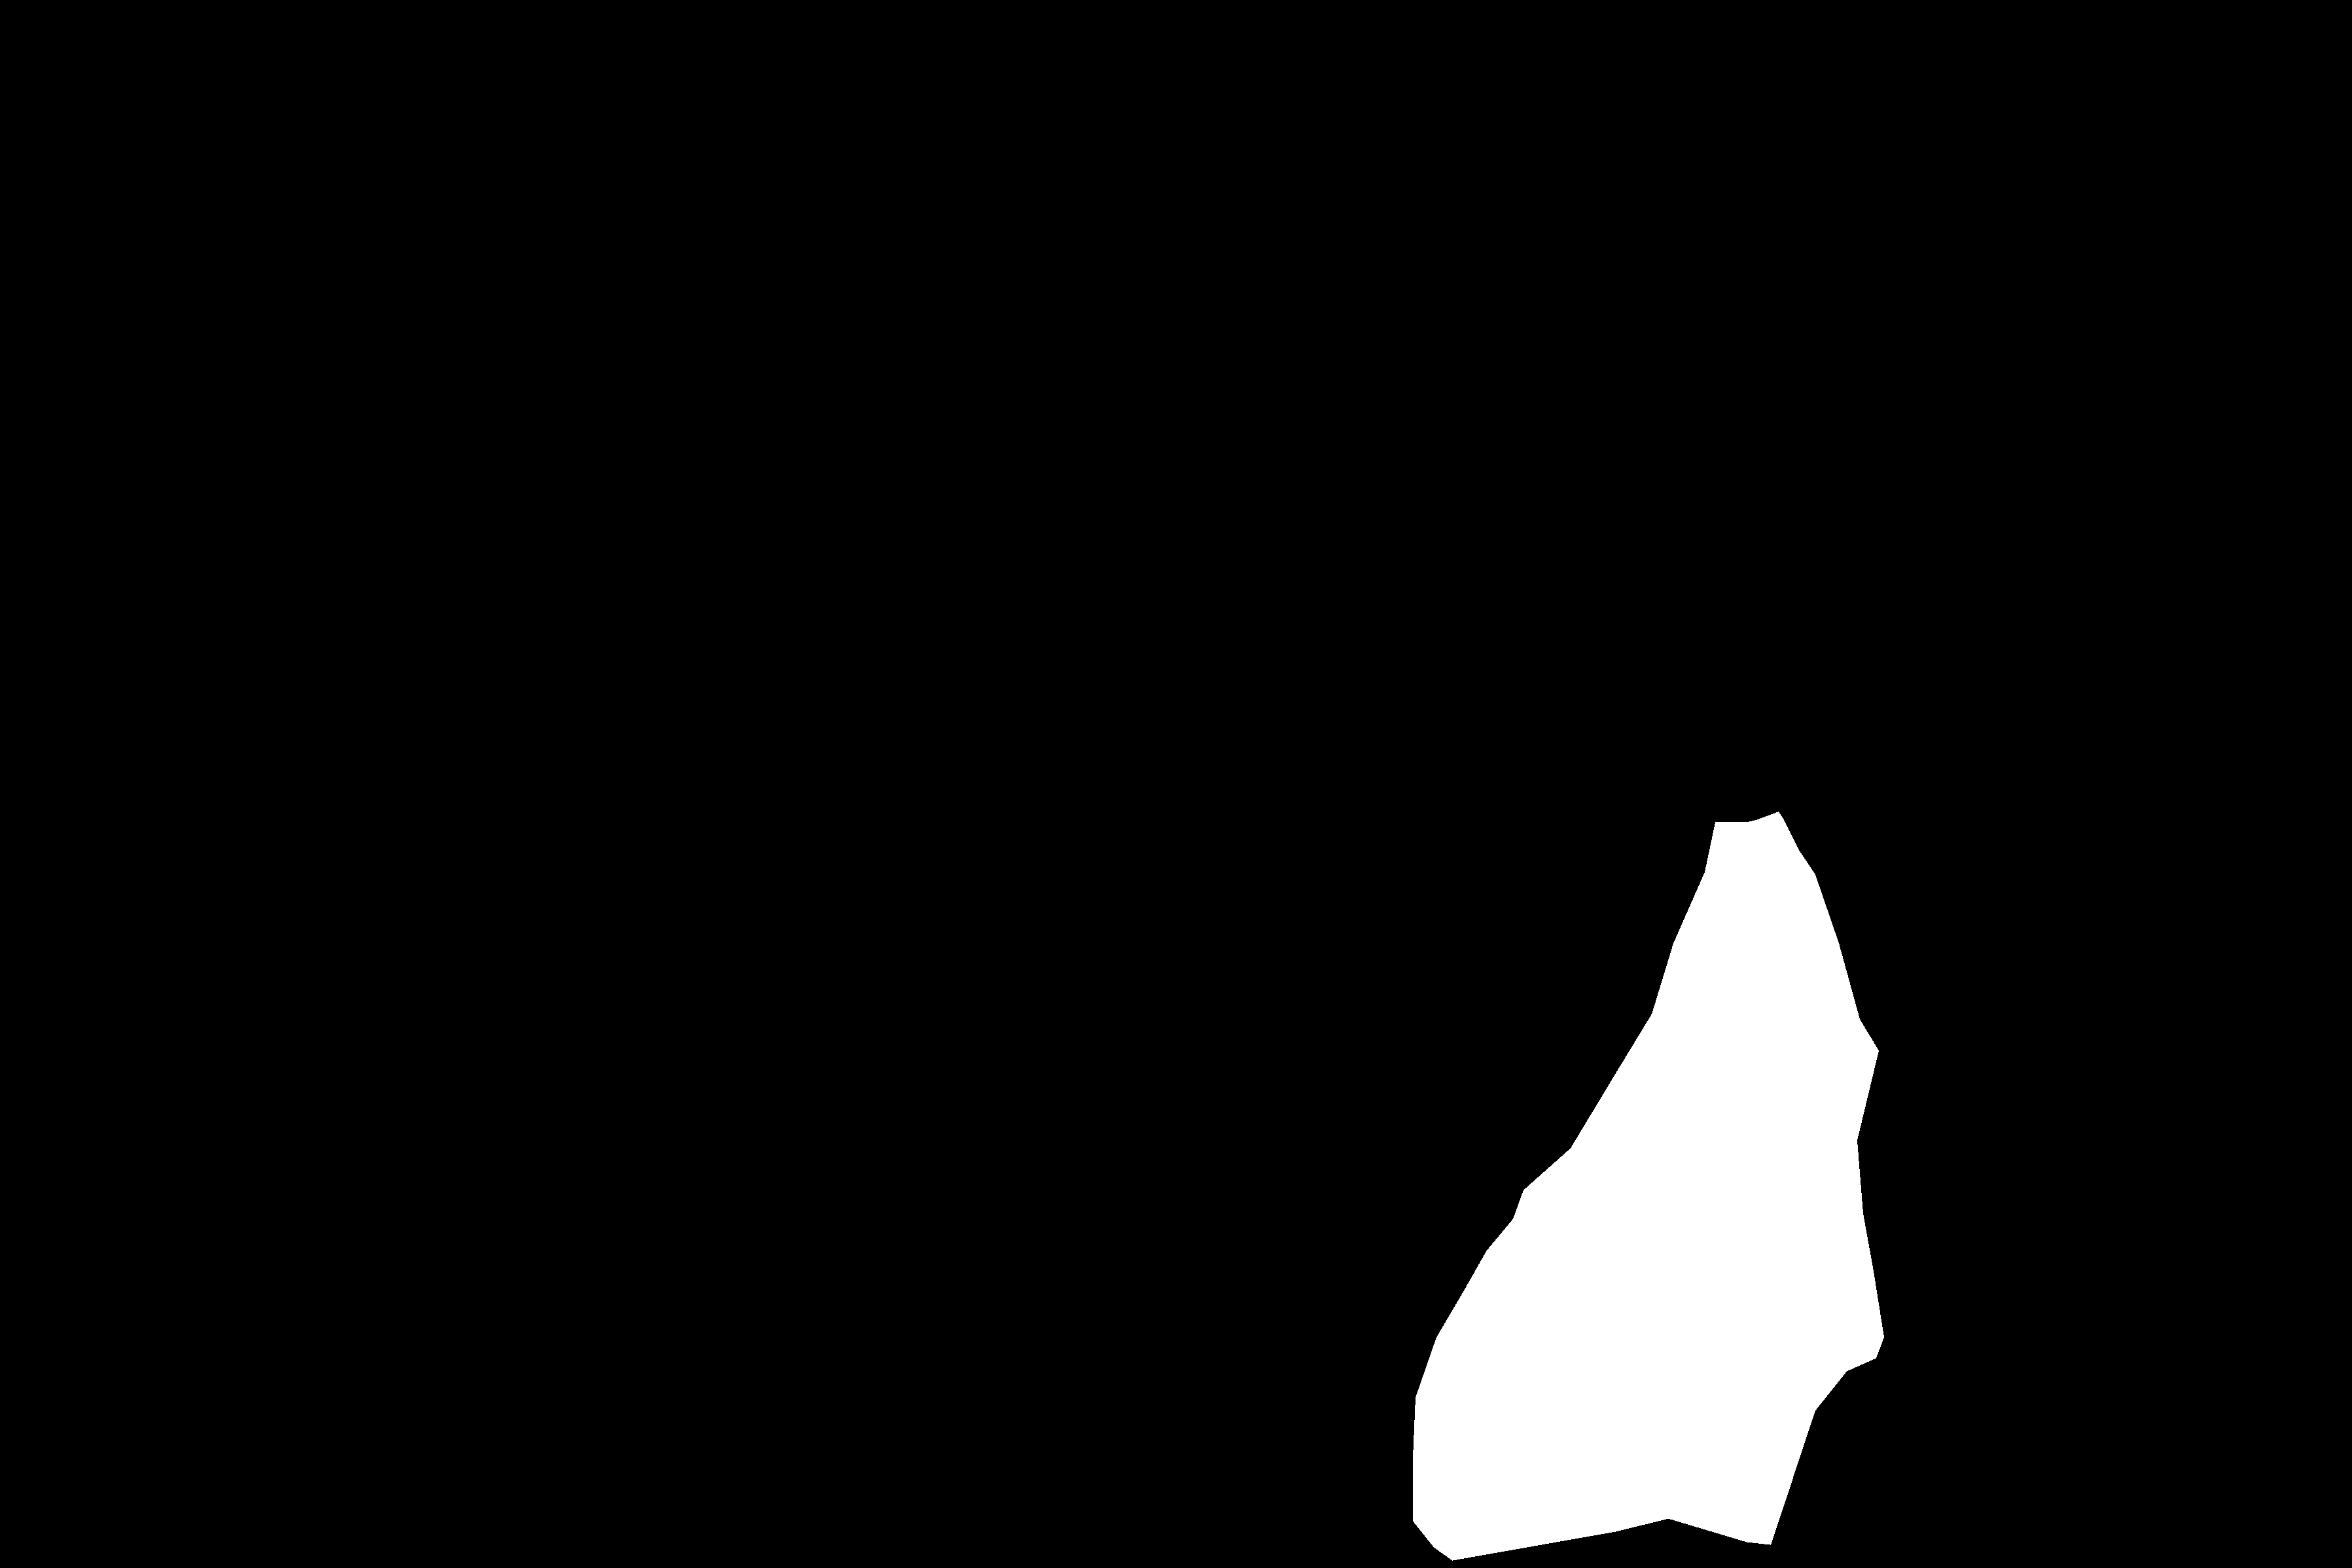

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=384x216 at 0x7F9149358F10>,
 {'area': tensor([822536.]),
  'boxes': tensor([[2159., 1240., 2878., 2384.]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0]),
  'labels': tensor([1]),
  'masks': tensor([[[[0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            ...,
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0]],
  
           [[0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            ...,
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0]],
  
           [[0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            ...,
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0]],
  
           ...,
  
           [[0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            ...,
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0]],
  
           [[0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            ...,
        

In [67]:
hofdataset = HOFDataset("./hand_over_face/")
hofdataset[0]